# Ship ML Experiment
Find the best model to predict gross tonnage of a ship! 

The approach can be divided into a few parts:
1. Explore the dataset and prepare the data 
2. Create new features 
3. Separate the data into train, validation and test set
4. Test feature importance 
5. Find correct algorithm and Hyperparameter tuning
7. Test the algorithm 



#### But first: import all necessary packages for the start of this ML project!


In [478]:

import pandas as pd 
import numpy as np 
from matplotlib import pyplot

import sklearn as sk
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR  

from scipy.stats import uniform, truncnorm, randint
from pprint import pprint

## Part 1a: explore the dataset 
First I explore the dataset. Although the set is small and column names and the number of rows can be seen immediately, I also get numeric values, type of the columns etc. Useful information for manual creation of features. 

I read in the data as a pandas dataframe. A dataframe allows for easy data exploration and data handling (column deletion, insertion etc.)

In [479]:
data = pd.read_csv("ship_data.csv", skiprows= 0)

In [480]:
# Check for null values 
data[data.isnull().any(axis=1)]

,Ship_name,Cruise_line,Age,cabins,crew,passengers,length,passenger_density,gross_tonnage


In [481]:
# Column names 
data.columns

Index(['Ship_name', 'Cruise_line', 'Age', 'cabins', 'crew', 'passengers',
       'length', 'passenger_density', 'gross_tonnage'],
      dtype='object')

In [482]:
# Information on number of columns, column types, number of rows
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ship_name          158 non-null    object 
 1   Cruise_line        158 non-null    object 
 2   Age                158 non-null    int64  
 3   cabins             158 non-null    float64
 4   crew               158 non-null    float64
 5   passengers         158 non-null    float64
 6   length             158 non-null    float64
 7   passenger_density  158 non-null    float64
 8   gross_tonnage      158 non-null    float64
dtypes: float64(6), int64(1), object(2)
memory usage: 11.2+ KB


In [483]:
# More information in numbers of the numeric columns. 'Name' is excluded 
data.describe()

,Age,cabins,crew,passengers,length,passenger_density,gross_tonnage
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,15.689873,8.830000,7.794177,18.457405,8.130633,39.900949,71.284671
std,7.615691,4.471417,3.503487,9.677095,1.793474,8.639217,37.229540
min,4.000000,0.330000,0.590000,0.660000,2.790000,17.700000,2.329000
25%,10.000000,6.132500,5.480000,12.535000,7.100000,34.570000,46.013000
50%,14.000000,9.570000,8.150000,19.500000,8.555000,39.085000,71.899000
75%,20.000000,10.885000,9.990000,24.845000,9.510000,44.185000,90.772500
max,48.000000,27.000000,21.000000,54.000000,11.820000,71.430000,220.000000


Additional information with help from the internet:
- Lenght is in foot (roughly 0.3 meters) x 100
- Number of passengers is x 100
- Number of crew is x 100
- Number of cabins is x 10 
- Passenger density the number of people per tonnage (so actually just passengers x passenger density = gross_tonnage?)
- Gross tonnage is x 100 

## Part 1b: prepare the data 
Before I'll split into train, validation and test set, I have to prepare some features. As we can see in the data, there are numeric features as well as object features. 

One of the features is the name of the ship. Assuming the name is not of importance to the prediction of the gross tonnage, we can leave this feature out of the data. 

Another feature is the "Cruise_line". This might be an important feature, but we do not know that now. 

In [484]:
data = data.drop(columns = ['Ship_name']).copy()

In [485]:
data["Cruise_line"].unique()
len(data["Cruise_line"].unique()) 

20

There are 20 unique values for "Cruise_line". Make it categorical using Label Encoding. This makes it easier for the model to handle, however it will lose some form of meaning. 

In [486]:
data['Cruise_line'] = data.Cruise_line.astype('category').cat.codes


In [487]:
data.head

<bound method NDFrame.head of      Cruise_line  Age  cabins   crew  passengers  length  passenger_density  \
0              0    6    3.55   3.55        6.94    5.94              42.64   
1              0    6    3.55   3.55        6.94    5.94              42.64   
2              1   26    7.43   6.70       14.86    7.22              31.80   
3              1   11   14.88  19.10       29.74    9.53              36.99   
4              1   17   13.21  10.00       26.42    8.92              38.36   
..           ...  ...     ...    ...         ...     ...                ...   
153           18   22    0.33   0.59        0.66    2.79              50.62   
154           18   14    9.67  12.00       19.60    8.79              39.18   
155           19   25    0.74   0.88        1.58    4.40              33.86   
156           19   27    0.74   0.88        1.67    4.40              32.04   
157           19   23    1.56   1.80        3.08    6.17              47.87   

     gross_tonnage  


In [488]:
# Get X and y to start with 
X = data.drop(columns = ['gross_tonnage']).copy()
y = data['gross_tonnage']

## Part 2: Create new features
As we expect and will see later, some of the features in the dataset are important for prediction of the gross tonnage, while other features are not. 

To make better predictions based on features, combinations of existing features might be predictors of the gross tonnage as well. 

Manually engineering features to improve the prediction power of the models:
- Passenger per cabin  
- Cabins per length 
- Passengers per length
- Total number of people by adding crew and passengers 


In [489]:
# Passenger per cabin 
# Cabins x 10
# Passengers x 100
# Length is in foot? Foot = 0.3 meter x 100
for i in range(158):
    X["passenger_per_cabin"] = X["cabins"] / (X["passengers"] / 10)
    X["length_per_cabin"] = X["cabins"] / X["length"]
    X["passengers_per_length"] = X["length"] / X["passengers"]
    X["total_people"] = X["crew"] + X["passengers"]

In [490]:
X.columns

Index(['Cruise_line', 'Age', 'cabins', 'crew', 'passengers', 'length',
       'passenger_density', 'passenger_per_cabin', 'length_per_cabin',
       'passengers_per_length', 'total_people'],
      dtype='object')

## Part 3: split into train, validation and test set
Train and test split as the usual practice, and addition of the validation set for the hyperparameter tuning. I opted for a small validation and test set, as the dataset has only 157 rows with data. 

Even though not completely necessary in a notebook, I've created a small function to return train, val and test set easily. 


In [526]:
def getTrainValTest(X, y, train_part, val_part):

    X_train, X_rest, y_train, y_rest = train_test_split(X,y, train_size=train_part, random_state = 1)

    test_part = 1 - train_part - val_part

    X_val, X_test, y_val, y_test = train_test_split(X_rest,y_rest, test_size=test_part, random_state = 1)

    return X_train, y_train, X_val, y_val, X_test, y_test


In [527]:
X_train, y_train, X_val, y_val, X_test, y_test = getTrainValTest(X,y, 0.8, 0.1)

## Part 4: find feature importance 
From the given list of columns, not all features will be equally important. Keeping all features might result in overfitting, which is why some features are not taken into account for the training of the classifier. 

First we try to get a baseline with 2 different models by using all features and then use a function to calculate their feature importance.

I opted for Linear regression, Random Forests and Support Vector Machines to get a quick and dirty indication of the possibly important features. 

In [528]:
feat_names = ['Cruise_line', 'Age', 'cabins', 'crew', 'passengers', 'length',
       'passenger_density', 'passenger_per_cabin', 'length_per_cabin',
       'passengers_per_length', 'total_people']

Feature: 0, Cruise_line, Score: -0.1086198878634815
Feature: 1, Age, Score: -0.11745182944880206
Feature: 2, cabins, Score: 7.5036533879831655
Feature: 3, crew, Score: 19807141590031.48
Feature: 4, passengers, Score: 19807141590031.6
Feature: 5, length, Score: 2.7103895033244845
Feature: 6, passenger_density, Score: 0.7287401897728549
Feature: 7, passenger_per_cabin, Score: -4.988840659451289
Feature: 8, length_per_cabin, Score: -34.7554516125747
Feature: 9, passengers_per_length, Score: -1.7858077153844263
Feature: 10, total_people, Score: -19807141590030.723


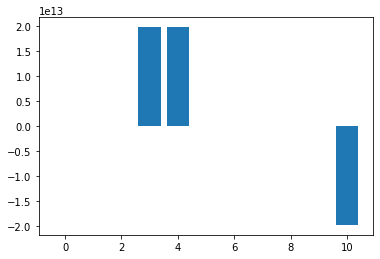

In [529]:
model = LinearRegression()

model.fit(X_train, y_train)

importance = model.coef_

for i,v in enumerate(importance):
	print('Feature: {0}, {1}, Score: {2}'.format(i, feat_names[i],v))

pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

From this we can see that feature 2,5, 7 and 8 are important, as they get more diverse coefficients 

Feature: 0, Cruise_line, Score: 0.0034982350481829487
Feature: 1, Age, Score: 0.011392107648683314
Feature: 2, cabins, Score: 0.1405249698145695
Feature: 3, crew, Score: 0.05785834813244517
Feature: 4, passengers, Score: 0.14398533237903202
Feature: 5, length, Score: 0.4192761202939308
Feature: 6, passenger_density, Score: 0.003172454238775755
Feature: 7, passenger_per_cabin, Score: 0.0014745048161034203
Feature: 8, length_per_cabin, Score: 0.030998200019601112
Feature: 9, passengers_per_length, Score: 0.012489464784984153
Feature: 10, total_people, Score: 0.17533026282369185


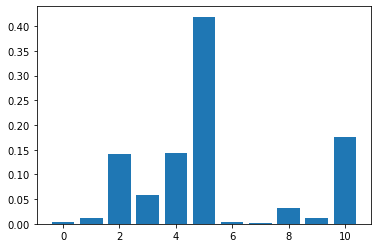

In [530]:
model = RandomForestRegressor()

model.fit(X_train, y_train)
importance = model.feature_importances_

for i,v in enumerate(importance):
	print('Feature: {0}, {1}, Score: {2}'.format(i, feat_names[i],v))

pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

- Feature 2: cabins
- Feature 5: length 
- Feature 10: total_people
These feature using a RF seem to have the highest feature importance. Passenger_per_cabin and passenger_density seem to have the lowest feature importance 

Feature: 0, Cruise_line, Score: 0.0005624678693677637
Feature: 1, Age, Score: 0.006335105496716475
Feature: 2, cabins, Score: 0.026112925313176733
Feature: 3, crew, Score: 0.061858418629336505
Feature: 4, passengers, Score: 0.007704218299280205
Feature: 5, length, Score: 0.77372614382642
Feature: 6, passenger_density, Score: 0.005941583478853064
Feature: 7, passenger_per_cabin, Score: 0.00021919778030905304
Feature: 8, length_per_cabin, Score: 0.027159277958458346
Feature: 9, passengers_per_length, Score: 0.0015062336837627338
Feature: 10, total_people, Score: 0.08887442766431897


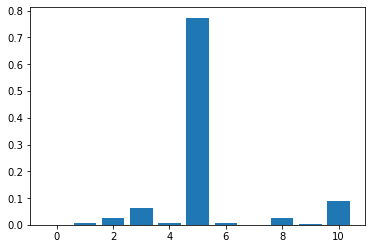

In [531]:
model = GradientBoostingRegressor()

model.fit(X_train, y_train)
importance = model.feature_importances_

for i,v in enumerate(importance):
	print('Feature: {0}, {1}, Score: {2}'.format(i, feat_names[i],v))

pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In the case of the GB, feature 4, 5 and 10 are important, which are "passengers, "length" and "total_people". 

So the features that we need to watch are "cabins", "length", as well as a feature that includes people (crew, passengers)

##### NOTE: 
It is actually quite interesting, because passenger_density * passengers gives gross tonnage, which is why I've expected that passengers and passenger_density both had higher feature importances. 

#### Features: to stay or to go?
As the name of the ship does not really matter for the classification (well, maybe it does after extensive search of keywords?), we can leave out this column. A similar thing can be said about Age. 

We try automatic selection of features using a Linear Regression classifier as baseline.  Instead of the test set, we use the validation set. 

In [532]:
def select_features(X_train, y_train, X_val, number):
	fs = SelectKBest(score_func=f_regression, k=number)

	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)

	X_val_fs = fs.transform(X_val)
	return X_train_fs, X_val_fs, fs

In [533]:
print("Linear Regression")

for i in range(1, 12):

	X_train_fs, X_val_fs, fs = select_features(X_train, y_train, X_val, i)

	model = LinearRegression()
	model.fit(X_train_fs, y_train)

	yhat = model.predict(X_val_fs)

	# Get the names of the features
	filter = fs.get_support()
	features = X_train.columns

	print("Best features are for number ", i, " are: ", features[filter])
	rmse = mean_squared_error(y_val, yhat, squared=False)
	print('RMSE: %.3f' % rmse)


Linear Regression
Best features are for number  1  are:  Index(['total_people'], dtype='object')
RMSE: 7.844
Best features are for number  2  are:  Index(['cabins', 'total_people'], dtype='object')
RMSE: 8.005
Best features are for number  3  are:  Index(['cabins', 'passengers', 'total_people'], dtype='object')
RMSE: 7.952
Best features are for number  4  are:  Index(['cabins', 'crew', 'passengers', 'total_people'], dtype='object')
RMSE: 7.987
Best features are for number  5  are:  Index(['cabins', 'crew', 'passengers', 'length', 'total_people'], dtype='object')
RMSE: 7.512
Best features are for number  6  are:  Index(['cabins', 'crew', 'passengers', 'length', 'length_per_cabin',
       'total_people'],
      dtype='object')
RMSE: 5.504
Best features are for number  7  are:  Index(['cabins', 'crew', 'passengers', 'length', 'length_per_cabin',
       'passengers_per_length', 'total_people'],
      dtype='object')
RMSE: 5.327
Best features are for number  8  are:  Index(['Age', 'cabins',

Best performance LR: 10 features 

In [534]:
print("Random Forest")

for i in range(1, 12):

	X_train_fs, X_val_fs, fs = select_features(X_train, y_train, X_val, i)

	model = RandomForestRegressor()
	model.fit(X_train_fs, y_train)

	yhat = model.predict(X_val_fs)

	# Get the names of the features
	filter = fs.get_support()
	features = X_train.columns

	print("Best features are for number ", i, " are: ", features[filter])
	rmse = mean_squared_error(y_val, yhat, squared=False)
	print('RMSE: %.3f' % rmse)



Random Forest
Best features are for number  1  are:  Index(['total_people'], dtype='object')
RMSE: 10.778
Best features are for number  2  are:  Index(['cabins', 'total_people'], dtype='object')
RMSE: 7.152
Best features are for number  3  are:  Index(['cabins', 'passengers', 'total_people'], dtype='object')
RMSE: 8.571
Best features are for number  4  are:  Index(['cabins', 'crew', 'passengers', 'total_people'], dtype='object')
RMSE: 7.163
Best features are for number  5  are:  Index(['cabins', 'crew', 'passengers', 'length', 'total_people'], dtype='object')
RMSE: 5.086
Best features are for number  6  are:  Index(['cabins', 'crew', 'passengers', 'length', 'length_per_cabin',
       'total_people'],
      dtype='object')
RMSE: 5.141
Best features are for number  7  are:  Index(['cabins', 'crew', 'passengers', 'length', 'length_per_cabin',
       'passengers_per_length', 'total_people'],
      dtype='object')
RMSE: 4.795
Best features are for number  8  are:  Index(['Age', 'cabins', 'c

Best performance RF: 7 features, followed by 6 features

In [535]:
print("Gradient Boosting")

for i in range(1, 12):

	X_train_fs, X_val_fs, fs = select_features(X_train, y_train, X_val, i)

	model = GradientBoostingRegressor()
	model.fit(X_train_fs, y_train)

	yhat = model.predict(X_val_fs)

	# Get the names of the features
	filter = fs.get_support()
	features = X_train.columns

	print("Best features are for number ", i, " are: ", features[filter])
	rmse = mean_squared_error(y_val, yhat, squared=False)
	print('RMSE: %.3f' % rmse)

Gradient Boosting
Best features are for number  1  are:  Index(['total_people'], dtype='object')
RMSE: 10.550
Best features are for number  2  are:  Index(['cabins', 'total_people'], dtype='object')
RMSE: 8.194
Best features are for number  3  are:  Index(['cabins', 'passengers', 'total_people'], dtype='object')
RMSE: 6.990
Best features are for number  4  are:  Index(['cabins', 'crew', 'passengers', 'total_people'], dtype='object')
RMSE: 5.588
Best features are for number  5  are:  Index(['cabins', 'crew', 'passengers', 'length', 'total_people'], dtype='object')
RMSE: 3.830
Best features are for number  6  are:  Index(['cabins', 'crew', 'passengers', 'length', 'length_per_cabin',
       'total_people'],
      dtype='object')
RMSE: 3.872
Best features are for number  7  are:  Index(['cabins', 'crew', 'passengers', 'length', 'length_per_cabin',
       'passengers_per_length', 'total_people'],
      dtype='object')
RMSE: 3.854
Best features are for number  8  are:  Index(['Age', 'cabins'

Best performance GB: 4 features, followed by 11 features. 

So all models perform better with a different subset of features. RF and GB with a lower number of features, LR with a higher number of features. 

### Manual subset testing
To explore the features further, I tried manual feature combinations. 

- Exclude Age and Cruiseline
- Exclude passenger_per_length and passengers
- Exclude crew and length_per_cabin 

I tried these removals. The first one I based on the earlier investigation using the importance of the models tried. The last four are features that were already embedded in other features (passengers and crew can be found in total_people) and they also scored low on the feature importance. 


In [536]:
# Baseline

print("Linear regression")
# Linear Regression 
model = LinearRegression()
model.fit(X_train, y_train)

yhat = model.predict(X_val)

mae = mean_absolute_error(y_val, yhat)
r2 = r2_score(y_val, yhat)
rmse = mean_squared_error(y_val, yhat, squared=False)
print('MAE LR: %.3f' % mae)
print('R2 LR: %.3f' % r2)
print('RMSE LR: %.3f' % rmse)

print("Random forest")
# Random Forest
model2 = RandomForestRegressor()
model2.fit(X_train, y_train)

yhat2 = model2.predict(X_val)

mae2 = mean_absolute_error(y_val, yhat2)
r2_2 = r2_score(y_val, yhat2)
rmse2 = mean_squared_error(y_val, yhat2, squared = False)
print('MAE RF: %.3f' % mae2)
print('R2 RF: %.3f' % r2_2)
print('RMSE RF: %.3f' % rmse2)

# Gradient Boosting 
print("Gradient Boosting")
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)

yhat_gb= reg.predict(X_val)

mae_gb = mean_absolute_error(y_val, yhat_gb)
r2_gb = r2_score(y_val, yhat_gb)
rmse_gb = mean_squared_error(y_val, yhat_gb, squared = False)
print('MAE GB: %.3f' % mae_gb)
print('R2 GB: %.3f' % r2_gb)
print('RMSE GB: %.3f' % rmse_gb)


Linear regression
MAE LR: 3.165
R2 LR: 0.984
RMSE LR: 4.231
Random forest
MAE RF: 3.022
R2 RF: 0.980
RMSE RF: 4.854
Gradient Boosting
MAE GB: 2.187
R2 GB: 0.990
RMSE GB: 3.331


In [537]:
# Exclude Age and Cruiseline 
subset_X_train = X_train[['cabins', 'crew', 'passengers', 'length',
       'passenger_density', 'passenger_per_cabin', 'length_per_cabin',
       'passengers_per_length', 'total_people']]
    
subset_X_val = X_val[['cabins', 'crew', 'passengers', 'length',
       'passenger_density', 'passenger_per_cabin', 'length_per_cabin',
       'passengers_per_length', 'total_people']]

In [538]:
# Exclude age and cruiseline
# Linear Regression 
print('Linear Regression')
modelsub = LinearRegression()
modelsub.fit(subset_X_train, y_train)

yhat_sub = modelsub.predict(subset_X_val)

mae_sub = mean_absolute_error(y_val, yhat_sub)
r2_sub = r2_score(y_val, yhat)
rmse_sub = mean_squared_error(y_val, yhat_sub, squared=False)
print('MAE LR_sub: %.3f' % mae_sub)
print('R2 LR_sub: %.3f' % r2_sub)
print('RMSE LR_sub: %.3f' % rmse_sub)

# Random Forest
print("Random Forest")
model2_sub = RandomForestRegressor()
model2_sub.fit(subset_X_train, y_train)

yhat2_sub = model2_sub.predict(subset_X_val)

mae2_sub = mean_absolute_error(y_val, yhat2_sub)
r2_2_sub = r2_score(y_val, yhat2_sub)
rmse2_sub = mean_squared_error(y_val, yhat2_sub, squared = False)
print('MAE RF_sub: %.3f' % mae2_sub)
print('R2 RF_sub: %.3f' % r2_2_sub)
print('RMSE RF_sub: %.3f' % rmse2_sub)

# gradient boosting 
print("Gradient boosting")
reg_sub = GradientBoostingRegressor(random_state=0)
reg_sub.fit(subset_X_train, y_train)

yhat_gb_sub= reg_sub.predict(subset_X_val)

mae_gb_sub = mean_absolute_error(y_val, yhat_gb_sub)
r2_gb_sub = r2_score(y_val, yhat_gb_sub)
rmse_gb_sub = mean_squared_error(y_val, yhat_gb_sub, squared = False)
print('MAE GB_sub: %.3f' % mae_gb_sub)
print('R2 GB_sub: %.3f' % r2_gb_sub)
print('RMSE GB_sub: %.3f' % rmse_gb_sub)

Linear Regression
MAE LR_sub: 3.045
R2 LR_sub: 0.984
RMSE LR_sub: 4.055
Random Forest
MAE RF_sub: 3.408
R2 RF_sub: 0.974
RMSE RF_sub: 5.461
Gradient boosting
MAE GB_sub: 2.326
R2 GB_sub: 0.989
RMSE GB_sub: 3.573


In [539]:
# Exclude passenger_per_cabin and crew 
subset_X_train = X_train[['cabins', 'passengers', 'length',
       'passenger_density', 'length_per_cabin',
       'passengers_per_length', 'total_people']]
    
subset_X_val = X_val[['cabins' , 'passengers', 'length',
       'passenger_density','length_per_cabin',
       'passengers_per_length', 'total_people']]

In [540]:
# Exclude passenger_per_cabin and crew 
# Linear Regression 
print('Linear Regression')

modelsub = LinearRegression()
modelsub.fit(subset_X_train, y_train)

yhat_sub = modelsub.predict(subset_X_val)

mae_sub = mean_absolute_error(y_val, yhat_sub)
r2_sub = r2_score(y_val, yhat)
rmse_sub = mean_squared_error(y_val, yhat_sub, squared=False)
print('MAE LR_sub: %.3f' % mae_sub)
print('R2 LR_sub: %.3f' % r2_sub)
print('RMSE LR_sub: %.3f' % rmse_sub)

# Random Forest
print("Random Forest")

model2_sub = RandomForestRegressor()
model2_sub.fit(subset_X_train, y_train)

yhat2_sub = model2_sub.predict(subset_X_val)

mae2_sub = mean_absolute_error(y_val, yhat2_sub)
r2_2_sub = r2_score(y_val, yhat2_sub)
rmse2_sub = mean_squared_error(y_val, yhat2_sub, squared = False)
print('MAE RF_sub: %.3f' % mae2_sub)
print('R2 RF_sub: %.3f' % r2_2_sub)
print('RMSE RF_sub: %.3f' % rmse2_sub)

# gradient boosting 
print("Gradient boosting")
reg_sub = GradientBoostingRegressor(random_state=0)
reg_sub.fit(subset_X_train, y_train)

yhat_gb_sub= reg_sub.predict(subset_X_val)

mae_gb_sub = mean_absolute_error(y_val, yhat_gb_sub)
r2_gb_sub = r2_score(y_val, yhat_gb_sub)
rmse_gb_sub = mean_squared_error(y_val, yhat_gb_sub, squared = False)
print('MAE GB_sub: %.3f' % mae_gb_sub)
print('R2 GB_sub: %.3f' % r2_gb_sub)
print('RMSE GB_sub: %.3f' % rmse_gb_sub)

Linear Regression
MAE LR_sub: 2.746
R2 LR_sub: 0.984
RMSE LR_sub: 3.558
Random Forest
MAE RF_sub: 3.398
R2 RF_sub: 0.973
RMSE RF_sub: 5.555
Gradient boosting
MAE GB_sub: 2.667
R2 GB_sub: 0.983
RMSE GB_sub: 4.472


In [541]:
# Exclude passenger_per_length and passengers
subset_X_train = X_train[['cabins',  'length', 'passenger_density',
        'length_per_cabin', 'total_people']]
    
subset_X_val = X_val[['cabins' ,  'length', 'passenger_density',
       'length_per_cabin', 'total_people']]

In [542]:
# Exclude passenger per length and passengers
# Linear Regression 
print('Linear Regression')

modelsub = LinearRegression()
modelsub.fit(subset_X_train, y_train)

yhat_sub = modelsub.predict(subset_X_val)

mae_sub = mean_absolute_error(y_val, yhat_sub)
r2_sub = r2_score(y_val, yhat)
rmse_sub = mean_squared_error(y_val, yhat_sub, squared=False)
print('MAE LR_sub: %.3f' % mae_sub)
print('R2 LR_sub: %.3f' % r2_sub)
print('RMSE LR_sub: %.3f' % rmse_sub)

# Random Forest
print("Random Forest")

model2_sub = RandomForestRegressor()
model2_sub.fit(subset_X_train, y_train)

yhat2_sub = model2_sub.predict(subset_X_val)

mae2_sub = mean_absolute_error(y_val, yhat2_sub)
r2_2_sub = r2_score(y_val, yhat2_sub)
rmse2_sub = mean_squared_error(y_val, yhat2_sub, squared = False)
print('MAE RF_sub: %.3f' % mae2_sub)
print('R2 RF_sub: %.3f' % r2_2_sub)
print('RMSE RF_sub: %.3f' % rmse2_sub)

# gradient boosting 
print("Gradient boosting")
reg_sub = GradientBoostingRegressor(random_state=0)
reg_sub.fit(subset_X_train, y_train)

yhat_gb_sub= reg_sub.predict(subset_X_val)

mae_gb_sub = mean_absolute_error(y_val, yhat_gb_sub)
r2_gb_sub = r2_score(y_val, yhat_gb_sub)
rmse_gb_sub = mean_squared_error(y_val, yhat_gb_sub, squared = False)
print('MAE GB_sub: %.3f' % mae_gb_sub)
print('R2 GB_sub: %.3f' % r2_gb_sub)
print('RMSE GB_sub: %.3f' % rmse_gb_sub)

Linear Regression
MAE LR_sub: 2.866
R2 LR_sub: 0.984
RMSE LR_sub: 3.721
Random Forest
MAE RF_sub: 3.403
R2 RF_sub: 0.973
RMSE RF_sub: 5.616
Gradient boosting
MAE GB_sub: 2.682
R2 GB_sub: 0.980
RMSE GB_sub: 4.858


After manual feature deletion, I have found that 5 features instead of 11 are sufficient for prediction: 'cabins',  'length', 'passenger_density', 'length_per_cabin', 'total_people'. I tried every exclusion of features with and without previously removed features. So for example, I tried inserting 'Cruise_line' and 'Age'  when I removed 'passenger_per_length'  and 'passengers'. This is my final verdict of important features: 3 already existing features and 2 manual features. 

As the dataset is not that large, I did not expect a large number of features. In comparison with the manual feature select of SelectKBest, other features are selected as most important for some algorithms. LR shows best performance using 10 features, GB using 4 features and RF using 6 features. I tried these features manually as well, but this shows a decrease in R2 score. As performance between the models differs and the optimal number of features differ as well using SelectKBest, I will keep the 5 manually selected features for the hyperparameter tuning of the final models as the performance seems to be better than with SelectKBest. It would be interesting to compare final performance with manual selected features vs. SelectKBest, but this would mean 3 x 2 hyperparameter tuning processes, so in this case I will keep it with the manual investigation and results. 

The feature passenger_density scored low in the earlier investigation of feature importance. But I tried removing this as well, but it does not work in combination with total_feature and removal of passengers. 


In [543]:
# Subset of X_train, X_val and X_test
subset_X_train = X_train[['cabins',  'length', 'passenger_density',
        'length_per_cabin', 'total_people']]
    
subset_X_val = X_val[['cabins' ,  'length', 'passenger_density',
       'length_per_cabin', 'total_people']]

subset_X_test = X_test[['cabins' ,  'length', 'passenger_density',
       'length_per_cabin', 'total_people']]


## Part 5: Choose algorithm for the regression task  and hyperparameter tuning
The algorithm of choice is determined by cross validation. The models compared are Linear Regression, Random Forests and Gradient Boosting. The baseline performance is the performance of the untuned models for the feature selection, shown underneath each model. I use the RandomizedSearchCV of sklearn, because this allows for K-Fold cross validation in a randomized way. It will select at random which values for the parameters will be sampled. 

### Linear regression 
As the data might be linear, Linear Regression would work fine by the KISS principle: keep it simple stupid. Why use a complex model that is more difficult to explain if we can also use a very simple model that is easy to interpret?

- MAE LR_sub: 3.899
- R2 LR_sub: 0.984
- RMSE LR_sub: 5.279

I found out that I cannot tune LR. I did not know this, but then the baseline is the final model. 

### Random Forests:
The Random Forest creates different Decision trees (ensemble of decision trees) and takes the average prediction. However, it cannot extrapolate, meaning that it is not able to obtain values outside ethe train set during prediction. It is not the best model when the data is linear. 

- MAE RF_sub: 4.625
- R2 RF_sub: 0.916
- RMSE RF_sub: 12.690

### Gradient Boosting:
The last model is Gradient boosting 

- MAE GB_sub: 4.613
- R2 GB_sub: 0.923
- RMSE GB_sub: 12.168

### Measurements
The model will be evaluated using Root Mean Squared Error and the R2 score. These metrics provide a baseline which we try to improve with hyperparameter tuning. 

In [544]:
lr = LinearRegression()
lr.fit(subset_X_train, y_train)

lr_yhat = lr.predict(subset_X_val)

r2_lr = r2_score(y_val, lr_yhat)
rmse_lr = mean_squared_error(y_val, lr_yhat, squared=False)
print('R2 LR: %.3f' % r2_lr)
print('RMSE LR: %.3f' % rmse_lr)


R2 LR: 0.988
RMSE LR: 3.721


In [545]:
# Random Forest tuning

rf = RandomForestRegressor()

rf_grid = {'bootstrap': [True, False],
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
               'max_features': ['auto', 'sqrt', 1,2,3,4,5],
               'min_samples_leaf': [1, 2, 3, 4, 8, 10, ],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [1,2,4,8,16,32,40, 50, 64,100, 120, 140, 150, 200]}

In [546]:
# Actual search

rf_search = RandomizedSearchCV(rf, rf_grid, n_iter=100, scoring = 'neg_root_mean_squared_error', cv=5, random_state = 1)


In [547]:
# Fit the model to the train set 
rf_model = rf_search.fit(subset_X_train, y_train)

In [548]:
# Print the parameters 
pprint(rf_model.best_estimator_.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [549]:
# Test the model with the validation set 
rf_yhat = rf_model.predict(subset_X_val)

r2_rf = r2_score(y_val, rf_yhat)
rmse_rf = mean_squared_error(y_val, rf_yhat, squared = False)
print('R2 rf: %.3f' % r2_rf)
print('RMSE rf: %.3f' % rmse_rf)


R2 rf: 0.971
RMSE rf: 5.799


In [550]:
# GB tuning 

gb = GradientBoostingRegressor()

gb_grid = {
    'n_estimators':[5,50,100,250,500],
    'max_depth':[1,3,5,7,9],
    'learning_rate':[0.01,0.1,1],
    'min_samples_leaf': [1, 2, 3, 4, 8, 10],
    'min_samples_split': [2, 5, 8, 10],
    'max_features': ['auto', 'sqrt', 'log2', None, 1,2,3,4,5]
}

In [551]:
# Actual search 

gb_search = RandomizedSearchCV(gb, gb_grid, n_iter=100, scoring = 'neg_root_mean_squared_error', cv=5, random_state = 1)


In [552]:
# Fit model to train set 
gb_model = gb_search.fit(subset_X_train, y_train)

In [553]:
# Print parameters
pprint(gb_model.best_estimator_.get_params())

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 7,
 'max_features': 3,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [554]:
# Test the model with the validation set

gb_yhat = gb_model.predict(subset_X_val)

r2_gb = r2_score(y_val, gb_yhat)
rmse_gb = mean_squared_error(y_val, gb_yhat, squared = False)
print('R2 rf: %.3f' % r2_gb)
print('RMSE rf: %.3f' % rmse_gb)

R2 rf: 0.979
RMSE rf: 4.896


## Part 7a: Testing per model

In [555]:
# Linear Regression
lr_yhat_test = lr.predict(subset_X_test)

r2_lr = r2_score(y_test, lr_yhat_test)
rmse_lr = mean_squared_error(y_test, lr_yhat_test, squared=False)
print('R2 LR: %.3f' % r2_lr)
print('RMSE LR: %.3f' % rmse_lr)

R2 LR: 0.981
RMSE LR: 4.503


In [556]:
# Random Forest

rf_yhat_test = rf_model.predict(subset_X_test)

r2_rf = r2_score(y_test, rf_yhat_test)
rmse_rf = mean_squared_error(y_test, rf_yhat_test, squared = False)
print('R2 rf: %.3f' % r2_rf)
print('RMSE rf: %.3f' % rmse_rf)

R2 rf: 0.996
RMSE rf: 1.996


In [557]:
# Gradient Boosting

gb_yhat_test = gb_model.predict(subset_X_test)

r2_gb = r2_score(y_test, gb_yhat_test)
rmse_gb = mean_squared_error(y_test, gb_yhat_test, squared = False)
print('R2 rf: %.3f' % r2_gb)
print('RMSE rf: %.3f' % rmse_gb)

R2 rf: 0.999
RMSE rf: 0.752


Gradient Boosting performs optimal on predicting the gross tonnage of ships using 5 features. 

## Part 7b: compare with passengers * passenger_density 

As I went through the column names, I did not know what "passenger_density was". When I looked it up online, I got the feeling that (passenger * passenger_density) / 10 is the gross tonnage. I tried this for a few values in Excell, so I will make predictions using only these 2 and compare this against the test. 

In [558]:
y_manual_prediction = (X_test["passengers"] * X_test["passenger_density"])/10

r2_manual = r2_score(y_test, y_manual_prediction)
rmse_manual = mean_squared_error(y_test, y_manual_prediction, squared = False)

print(y_manual_prediction)
print(y_test)

print('RMSE manual: %.3f' % rmse_manual)

78     90.99420
81     81.00032
143    10.00064
51     83.00250
dtype: float64
78     91.0
81     81.0
143    10.0
51     83.0
Name: gross_tonnage, dtype: float64
RMSE manual: 0.003
